In [156]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer
from hmmlearn import hmm
from scipy import stats
import statsmodels.formula.api as smf

from psyfun import io, atlas, spikes, util, plots
from psyfun.config import *

In [157]:
# Load session info
df_sessions = io.load_sessions()  # session info 

In [236]:
df_sessions = util.get_insertion_trajectory_labels(df_sessions)

In [238]:
df_units = io.load_units()
df_units['coarse_region'] = atlas.coarse_regions(df_units['region'])  # convert specific anatomical acronym to more coarse parcellation

In [239]:
print(f"Total sessions: {len(df_sessions)}")

# Remove sessions missing timing information for important experimental epochs
task_epochs = ['task00_spontaneous_start', 'task01_spontaneous_start', 'task00_replay_start', 'task01_replay_start']
df_sessions = df_sessions.dropna(subset=task_epochs)


# JA: drop massive outlier from my recordings, this recording should probably be removed from the dataset altogether
# Recording from ZFM-08457 on 2025-03-20, eid: 'e31bff07-d66c-4a03-894d-f71030161ead'
# Notes from recording: No spikes!!! -> SAC!
# To drop the session, run:
# df_sessions = df_sessions[df_sessions['eid'] != 'e31bff07-d66c-4a03-894d-f71030161ead']

print(f"Remaining sessions: {len(df_sessions)}")

Total sessions: 35
Remaining sessions: 35


In [240]:
# Get eids for remaining sessions
eids = df_sessions['eid'].tolist()
df_units = df_units.query('eid in @eids')
print(f"Total units: {len(df_units)}")

# Some useful filters:
unit_filter = 'ks2_label == "good"'  # kilosort label for well-isolated units, as opposed to multi-unit activity (mua)
# unit_filter = 'label == 1.0'  # more conservative IBL quality criterion
# Additional filters can be constructed using any column of the unit metadata
# print(df_units.columns)

# Remove low-quality units
df_units = df_units.query(unit_filter)
print(f"Remaining units: {len(df_units)}")

Total units: 79454
Remaining units: 14886


In [241]:
# Load spike times
df_spiketimes = io.load_spikes(df_units['uuid'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:03<00:00, 4344.68it/s]


In [242]:
# Join spike times with unit info
df_spikes = df_units.set_index('uuid').join(df_spiketimes).reset_index()

# Merge session info into spikes dataframe
df_spikes = pd.merge(df_spikes, df_sessions, on=['subject', 'eid', 'session_n'], how='left')
# Clean up columns after merge
df_spikes = df_spikes[[col for col in df_spikes.columns if not col.endswith('_x') or col.endswith('_y')]]

In [244]:
df_spikes['full_start'] = df_spikes[[col for col in df_spikes.columns if '_start' in col]].min(axis='columns')
df_spikes['full_stop'] = df_spikes[[col for col in df_spikes.columns if '_stop' in col]].max(axis='columns')

# Epochs defined by visual stimulation protocol
task_epochs = [  
    'task00_spontaneous', 
    'task01_spontaneous', 
    'task00_replay',
    'task01_replay',
    'full'
]

# Pick a set of epochs from which we will get spike counts and run PCA
epochs = task_epochs

# Get spike counts for epochs
dt = 1  # seconds
for epoch in epochs:
    print(f"Getting spike counts for: {epoch}")
    # Convert spike times to spike counts in bins of size dt
    df_spikes[f'{epoch}_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch=epoch, dt=dt, axis='columns')
    # Compute mean firing rate from array of spike counts
    df_spikes[f'{epoch}_rate'] = df_spikes[f'{epoch}_counts'].apply(lambda x: (x / dt).mean())

Getting spike counts for: task00_spontaneous


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 5403.13it/s]


Getting spike counts for: task01_spontaneous


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 5790.50it/s]


Getting spike counts for: task00_replay


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 6507.01it/s]


Getting spike counts for: task01_replay


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 6336.29it/s]


Getting spike counts for: full


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:04<00:00, 3234.50it/s]


In [245]:
var_exp = []
for _, session in df_spikes.groupby('eid'):
    if len(session) < 100:
        continue
    X = np.stack(session['full_counts']).T
    X_norm = StandardScaler().fit_transform(X)
    pca = PCA()
    X_pcs = pca.fit_transform(X_norm) 
    var_exp.append(pca.explained_variance_ratio_)

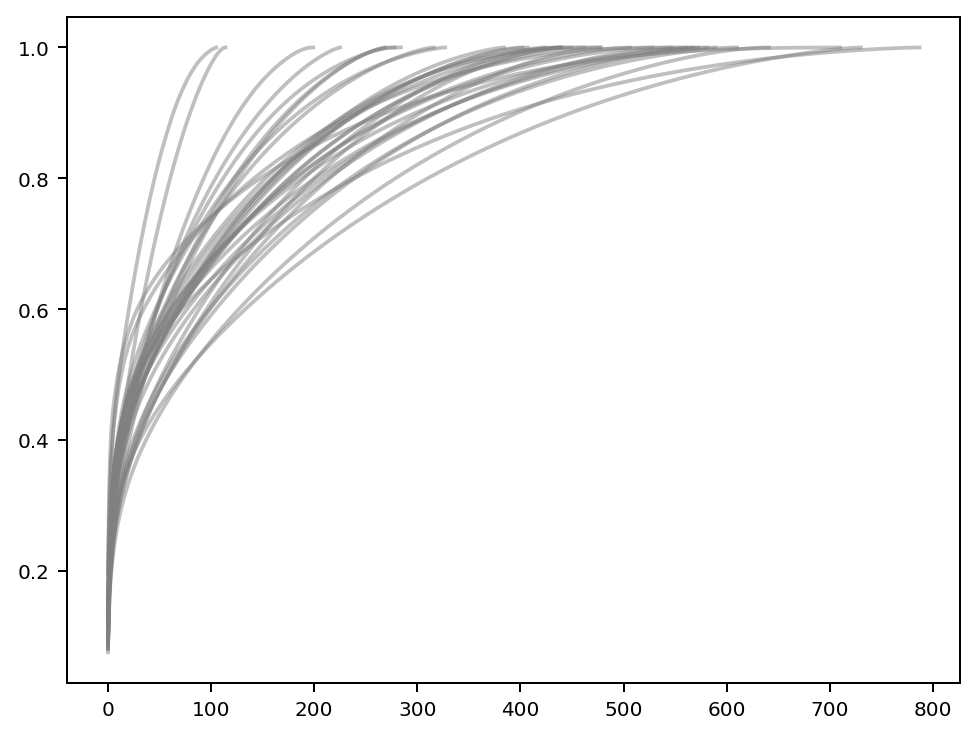

In [246]:
fig, ax = plt.subplots()
for var in var_exp:
    ax.plot(np.cumsum(var), color='gray', alpha=0.5)

In [37]:
from hmmlearn import hmm

def get_state_occupancy(states, n_states):
    """Calculate proportion of time in each state."""
    occupancy = np.bincount(states, minlength=n_states) / len(states)
    return occupancy

def evaluate_hmm(states, bin_size):
    """Check if states are reasonable."""
    # State durations
    state_changes = np.diff(states) != 0
    durations = np.diff(np.where(np.concatenate([[True], state_changes, [True]]))[0])
    mean_duration = durations.mean() * bin_size
    
    print(f"Mean state duration: {mean_duration:.2f}s")
    print(f"Number of transitions: {state_changes.sum()}")
    
    # Check for flickering (very short states)
    short_states = (durations == 1).sum() / len(durations)
    print(f"Proportion of 1-bin states: {short_states:.2%}")
    
    return durations

In [338]:
epochs = [
    'task00_spontaneous',
    'task01_spontaneous',
    'task00_replay',
    'task01_replay'
]
columns_to_keep = ['subject', 'eid', 'session_n', 'control_recording', 'start_time', 'trajectory_label']

K = 7

# eid = df_spikes['eid'].unique()[12]
# session = df_spikes.query('eid == @eid')
# regions = ['Striatum', 'Thalamus', 'Prefrontal Ctx', 'Supp. Motor Ctx', 'Motor Ctx']
# session = df_spikes.query('eid == @eid and coarse_region in @regions')

hmm_datas = []
sessions = df_spikes.groupby('eid')
for _, neurons in tqdm(sessions, total=len(sessions)):
    if len(neurons) < 100:
        continue
    hmm_data = {col: neurons[col].unique()[0] for col in columns_to_keep}
    hmm_data['coarse_regions'] = neurons['coarse_region'].value_counts().to_dict()
    
    # Dimensionality reduction on full recording
    X = np.stack(neurons['full_counts']).T
    X_norm = StandardScaler().fit_transform(X)
    pca = PCA()
    pca.fit(X_norm)
    D = np.searchsorted(np.cumsum(pca.explained_variance_ratio_), 0.8)
        
    for epoch in epochs:
        X = np.stack(neurons[f'{epoch}_counts']).T
        X_norm = StandardScaler().fit_transform(X)
        X_pca = pca.transform(X_norm)
        
        model = hmm.GaussianHMM(n_components=K, covariance_type='diag', n_iter=200, tol=0.001, random_state=1, algorithm='viterbi')
        model.fit(X_pca[:, :D])
        # ll = model.score(X_pca[:, :D])
        # print(ll)
        posteriors = model.predict_proba(X_pca[:, :D])
        states = model.predict(X_pca[:, :D])
        # durations = evaluate_hmm(states, dt)
        
        hmm_data[f'{epoch}_converged'] = model.monitor_.converged
        hmm_data[f'{epoch}_posteriors'] = posteriors
        hmm_data[f'{epoch}_states'] = states
        hmm_data[f'{epoch}_occupancy'] = get_state_occupancy(states, K)
    hmm_datas.append(hmm_data)
df_hmm = pd.DataFrame(hmm_datas)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:35<00:00,  1.04s/it]


In [339]:
df_hmm = df_hmm[df_hmm[[col for col in df_hmm.columns if col.endswith('_converged')]].all(axis=1)]

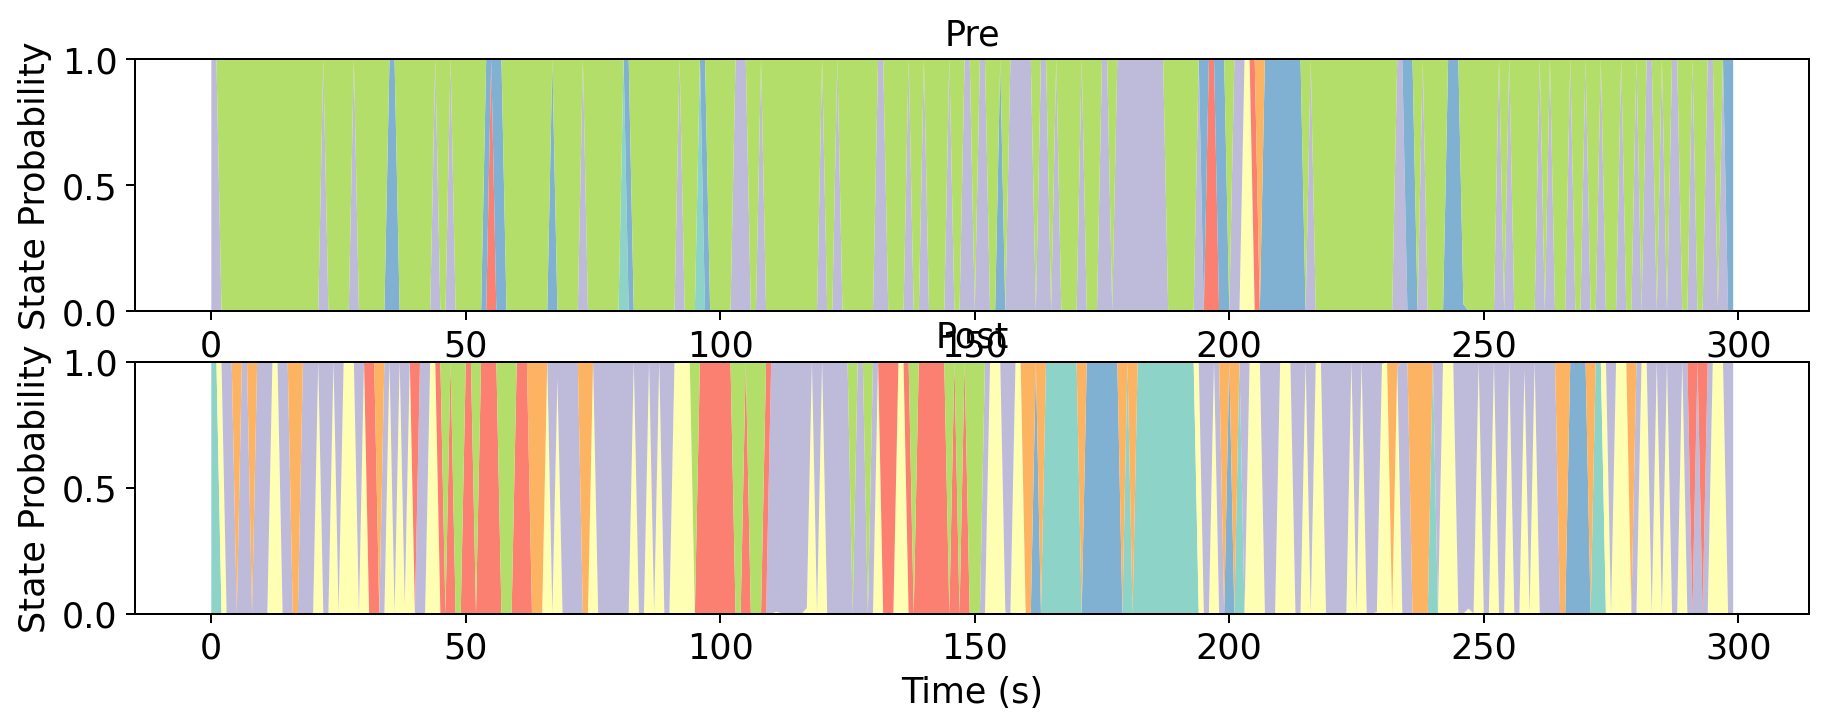

In [362]:
session = df_hmm.iloc[1]
epochs = [
    'task00_spontaneous',
    'task01_spontaneous'
]

fig, axs = plt.subplots(len(epochs), figsize=(12, 2 * len(epochs)))

for ax, epoch in zip(axs, epochs):
    posteriors = session[f'{epoch}_posteriors']
    tpts = np.arange(len(posteriors)) * dt  # Convert bins to seconds
    ax.stackplot(tpts, posteriors.T, labels=[f'State {i}' for i in range(K)], colors=plt.cm.Set3(range(7)))
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('State Probability')
    ax.set_ylim(0, 1)
    ax.set_title('Pre' if epoch == 'task00_spontaneous' else 'Post')
# axs[0].legend(loc='lower left', bbox_to_anchor=(0, 1), ncol=K)
# plots.set_plotsize(w=18, h=12, ax=ax)
fig.savefig('figures/HMM_posteriors.svg')

Text(0.5, 1.0, 'State duration distribution')

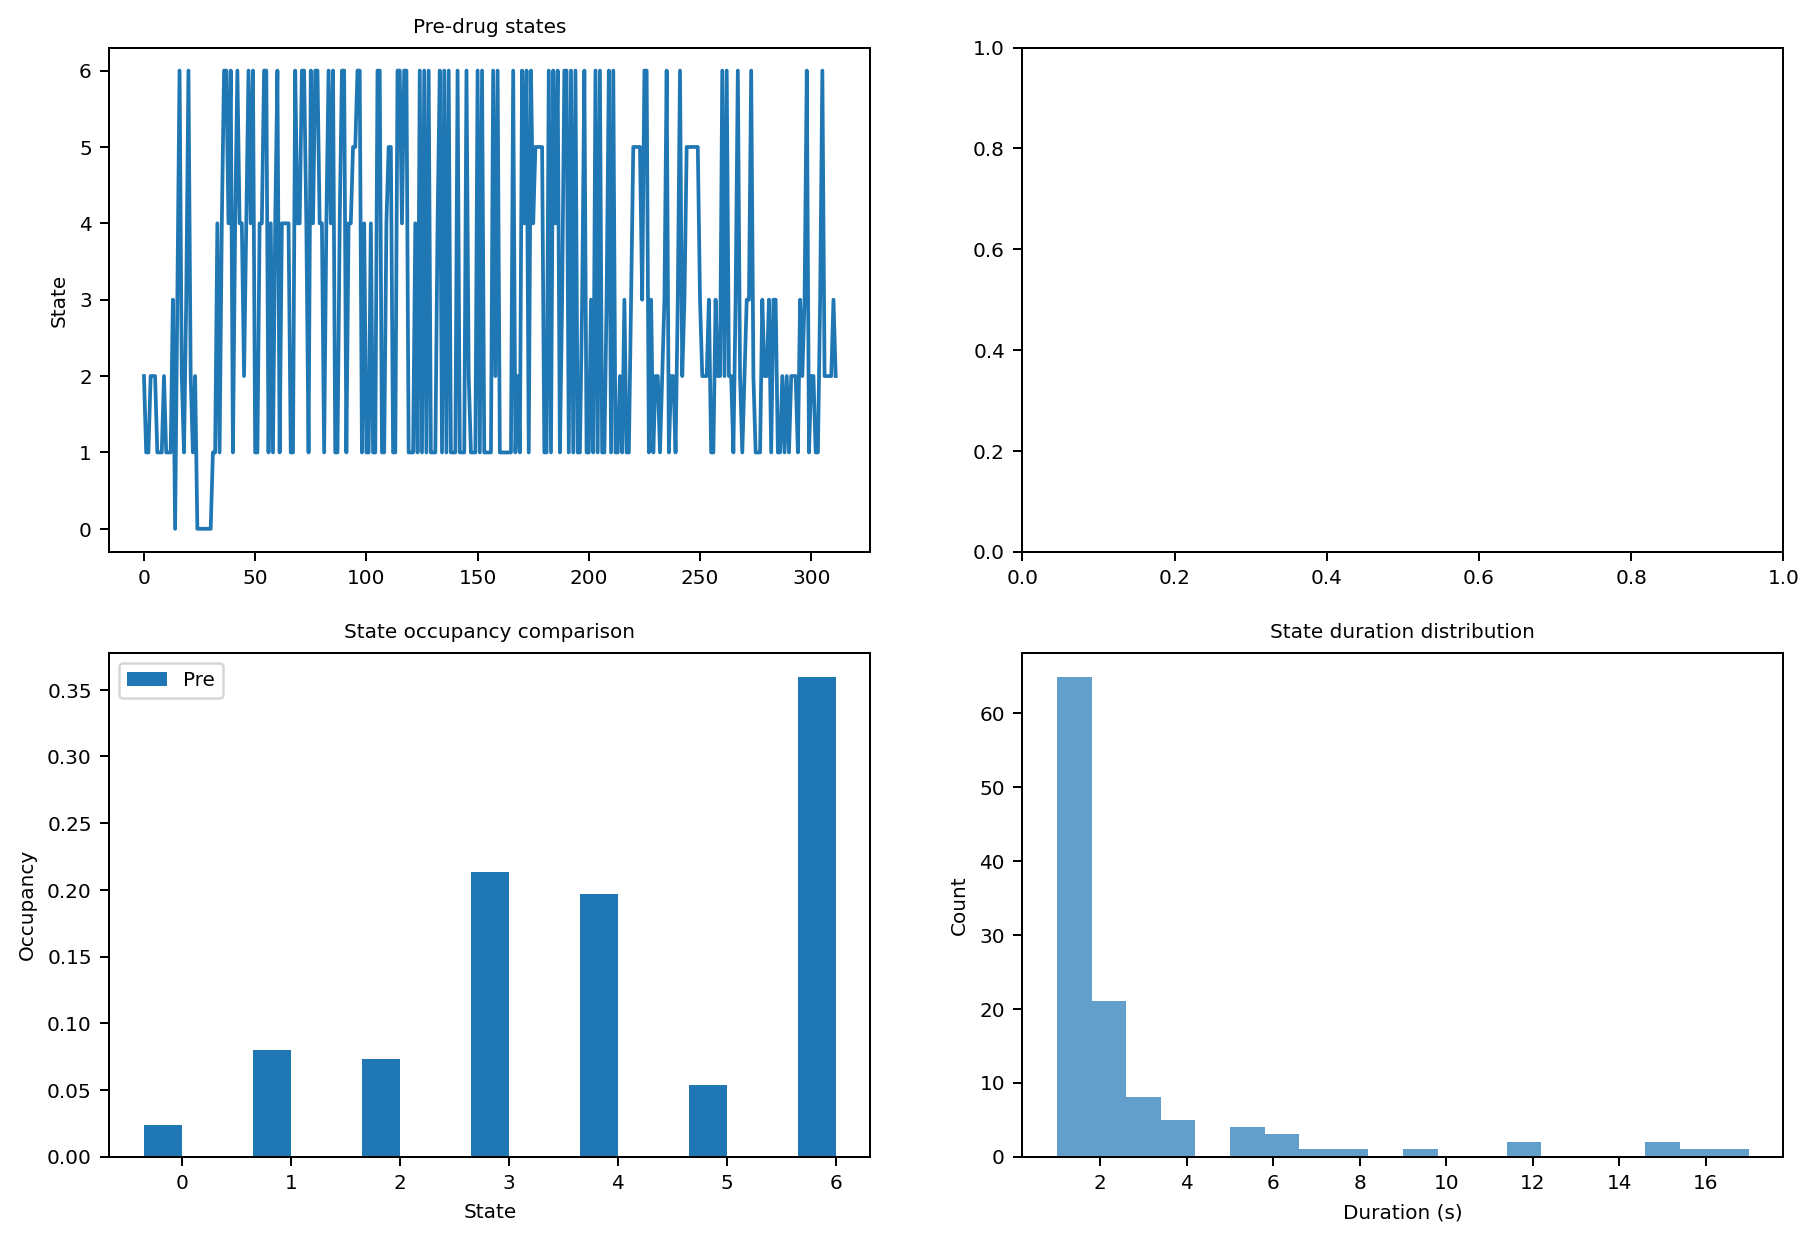

In [296]:
# 8. Visualize results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# State sequences
axes[0, 0].plot(states)
axes[0, 0].set_title('Pre-drug states')
axes[0, 0].set_ylabel('State')

# axes[0, 1].plot(states_post)
# axes[0, 1].set_title('Post-drug states')

# State occupancy comparison
x = np.arange(K)
width = 0.35
axes[1, 0].bar(x - width/2, occupancy, width, label='Pre')
# axes[1, 0].bar(x + width/2, occupancy_post, width, label='Post')
axes[1, 0].set_xlabel('State')
axes[1, 0].set_ylabel('Occupancy')
axes[1, 0].set_title('State occupancy comparison')
axes[1, 0].legend()

# State duration distributions
axes[1, 1].hist(durations * dt, bins=20, alpha=0.7)
axes[1, 1].set_xlabel('Duration (s)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('State duration distribution')

In [363]:
epochs = [
    'task00_spontaneous',
    'task01_spontaneous',
    'task00_replay',
    'task01_replay'
]

for epoch in epochs:
    df_hmm[f'{epoch}_entropy'] = df_hmm[f'{epoch}_occupancy'].apply(util.normalized_entropy)
    df_hmm[f'{epoch}_S1'] = df_hmm[f'{epoch}_occupancy'].apply(lambda x: x.max())
    df_hmm[f'{epoch}_lzc'] = df_hmm[f'{epoch}_states'].apply(lambda x: lziv_complexity(x, normalize=True))

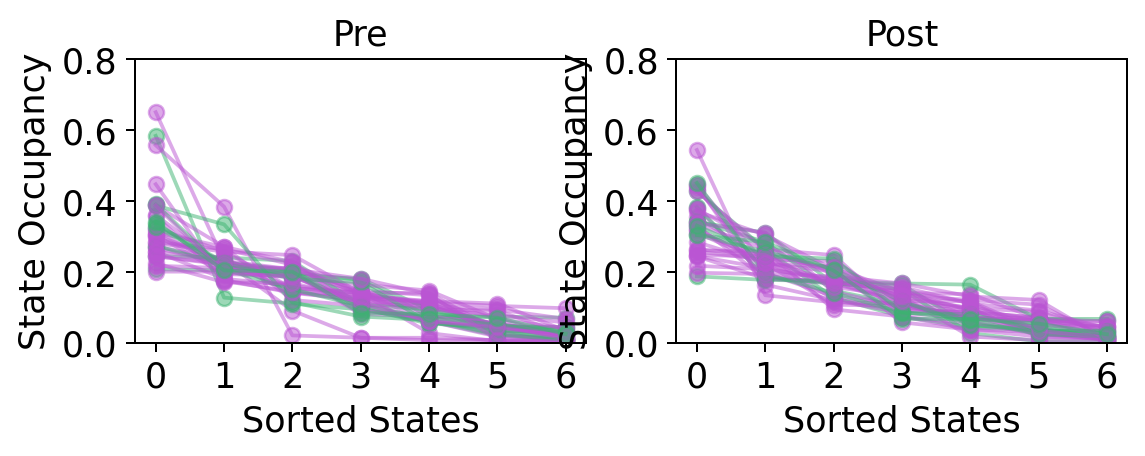

In [366]:
epoch = 'spontaneous'

fig, axs = plt.subplots(1, 2)

for ax, task, label in zip(axs, ['task00', 'task01'], ['Pre', 'Post']):
    for idx, session in df_hmm.iterrows():
        # Sort states by occupancy
        sorted_occupancies = np.flip(np.sort(session[f'{task}_{epoch}_occupancy']))
        
        # Create x positions for each state
        xx = np.arange(K)
        yy = sorted_occupancies
        
        # Pick a color based on condition
        color = CONTROLCOLOR if session['control_recording'] else LSDCOLOR
        
        # Plot connected line for this session
        ax.plot(xx, yy, color=color, marker='o', alpha=0.5)
    
    # Format axes
    ax.set_xticks(range(K))
    ax.set_xlabel('Sorted States')
    ax.set_ylim([0, 0.8])
    ax.set_ylabel(f'State Occupancy')
    ax.set_title(label)
    plots.set_plotsize(w=14, h=4)
fig.savefig('figures/HMM_occupancy.svg')

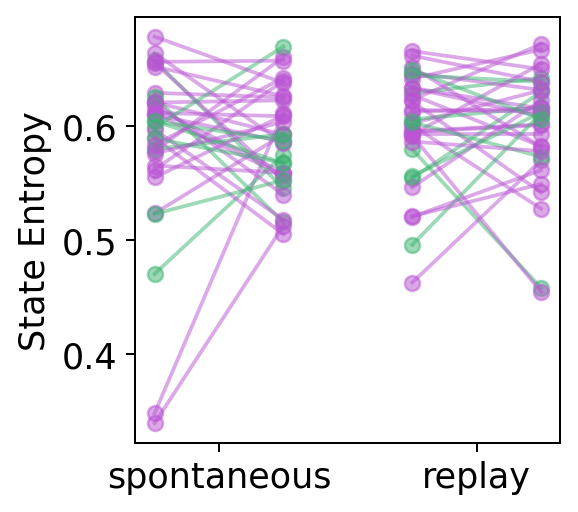

In [368]:
epoch_pairs = [  
    ['task00_spontaneous', 'task01_spontaneous'],
    ['task00_replay', 'task01_replay']
]

fig, ax = plt.subplots()
xoffset = 0.25  # determines spacing between pairs of points

for idx, session in df_hmm.iterrows():
    pos = 0  # increment x-position for each epoch pair
    for epochs in epoch_pairs:
        # Get the data to plot
        xx = pos + np.array([-xoffset, xoffset])
        yy = np.array([session[f'{epoch}_entropy'] for epoch in epochs])

        # Pick a color and linestyle
        color = CONTROLCOLOR if session['control_recording'] else LSDCOLOR
        
        # Plot pairs
        ax.plot(xx, yy, color=color, marker='o', alpha=0.5)
        
        pos += 1  # increment x-position

# Format axes
ax.set_xticks(range(len(epoch_pairs)))
ax.set_xticklabels([epochs[0].split('_')[1] for epochs in epoch_pairs])
ax.set_ylabel('State Entropy')
plots.set_plotsize(w=6, h=6)

fig.savefig('figures/HMM_entropy.svg')

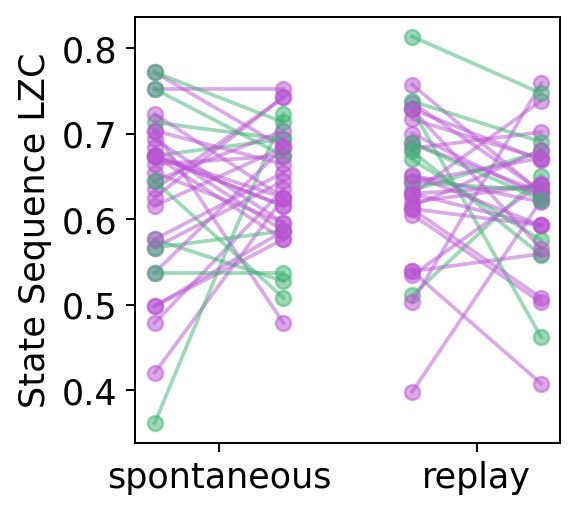

In [371]:
epoch_pairs = [  
    ['task00_spontaneous', 'task01_spontaneous'],
    ['task00_replay', 'task01_replay']
]

fig, ax = plt.subplots()
xoffset = 0.25  # determines spacing between pairs of points

for idx, session in df_hmm.iterrows():
    pos = 0  # increment x-position for each epoch pair
    for epochs in epoch_pairs:
        # Get the data to plot
        xx = pos + np.array([-xoffset, xoffset])
        yy = np.array([session[f'{epoch}_lzc'] for epoch in epochs])

        # Pick a color and linestyle
        color = CONTROLCOLOR if session['control_recording'] else LSDCOLOR
        
        # Plot pairs
        ax.plot(xx, yy, color=color, marker='o', alpha=0.5)
        
        pos += 1  # increment x-position

# Format axes
ax.set_xticks(range(len(epoch_pairs)))
ax.set_xticklabels([epochs[0].split('_')[1] for epochs in epoch_pairs])
ax.set_ylabel('State Sequence LZC')
plots.set_plotsize(w=6, h=6)

fig.savefig('figures/HMM_lzc.svg')

In [301]:
# Convert dataframe to long format
df_metric = df_hmm.melt(
    id_vars=['subject', 'eid', 'control_recording', 'trajectory_label'],
    value_vars=[col for col in df_hmm.columns if col.endswith(f'_entropy')],
    var_name='epoch',
    value_name='entropy'
).query('epoch.str.contains("task")').dropna()  # this ensures we are only including task_epochs

# Here, we split the task_epochs into two factors the task factor (pre or post treatment) and the epoch factor (visual sitmulation condition)
df_metric['task'] = df_metric['epoch'].apply(lambda x: x.split('_')[0])
df_metric['epoch'] = df_metric['epoch'].apply(lambda x: x.split('_')[1])

epochs = ['spontaneous', 'replay']
df_metric = df_metric[df_metric['epoch'].apply(lambda x: x in epochs)]  # Take only epochs of interest


# Build composite varibale for grouping
df_metric['subject_trajectory'] = df_metric.apply(lambda x: '_'.join([x['subject'], x['trajectory_label']]), axis='columns')

# Fit model with joint effects and random slopes/intercepts for each eid
model = smf.mixedlm(f'entropy ~ C(task, Treatment("task00")) + C(epoch, Treatment("spontaneous")) + C(control_recording) + ' + 
                    f'C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous")) + C(task, Treatment("task00"))*C(control_recording) + C(epoch, Treatment("spontaneous"))*C(control_recording)', 
                    data=df_metric,
                    ## FIXME: grouping variable should be mouse_trajectory composite variable
                    groups=df_metric['subject_trajectory'],  # Group by session
                    re_formula='~C(task, Treatment("task00")) + C(epoch, Treatment("spontaneous")) + C(control_recording) + ' +
                    'C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous")) + C(task, Treatment("task00"))*C(control_recording) + C(epoch, Treatment("spontaneous"))*C(control_recording)'
                   )  # Random slopes for all within-group predictors
result = model.fit()
print(result.summary())

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                                                                    Mixed Linear Model Regression Results
Model:                                                                MixedLM                                                   Dependent Variable:                                                   entropy 
No. Observations:                                                     132                                                       Method:                                                               REML    
No. Groups:                                                           29                                                        Scale:                                                                0.0016  
Min. group size:                                                      4                                                         Log-Likelihood:                                                       185.1782
Max. group size:                                  

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


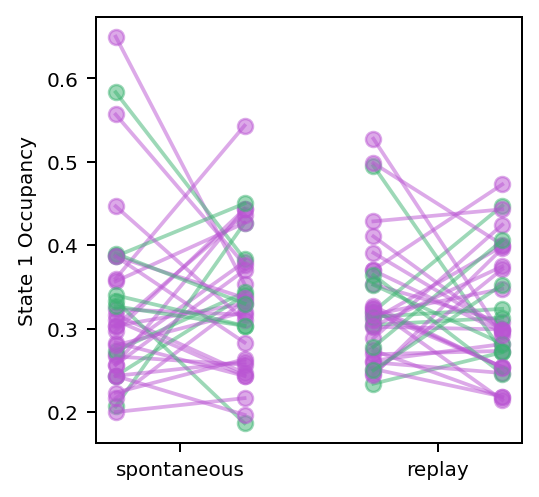

In [302]:
epoch_pairs = [  
    ['task00_spontaneous', 'task01_spontaneous'],
    ['task00_replay', 'task01_replay']
]

fig, ax = plt.subplots()
xoffset = 0.25  # determines spacing between pairs of points

for idx, session in df_hmm.iterrows():
    pos = 0  # increment x-position for each epoch pair
    for epochs in epoch_pairs:
        # Get the data to plot
        xx = pos + np.array([-xoffset, xoffset])
        yy = np.array([session[f'{epoch}_S1'] for epoch in epochs])

        # Pick a color and linestyle
        color = CONTROLCOLOR if session['control_recording'] else LSDCOLOR
        
        # Plot pairs
        ax.plot(xx, yy, color=color, marker='o', alpha=0.5)
        
        pos += 1  # increment x-position

# Format axes
ax.set_xticks(range(len(epoch_pairs)))
ax.set_xticklabels([epochs[0].split('_')[1] for epochs in epoch_pairs])
ax.set_ylabel('State 1 Occupancy')
plots.set_plotsize(w=6, h=6)

In [303]:
# Convert dataframe to long format
df_metric = df_hmm.melt(
    id_vars=['subject', 'eid', 'control_recording', 'trajectory_label'],
    value_vars=[col for col in df_hmm.columns if col.endswith(f'_S1')],
    var_name='epoch',
    value_name='S1'
).query('epoch.str.contains("task")').dropna()  # this ensures we are only including task_epochs

# Here, we split the task_epochs into two factors the task factor (pre or post treatment) and the epoch factor (visual sitmulation condition)
df_metric['task'] = df_metric['epoch'].apply(lambda x: x.split('_')[0])
df_metric['epoch'] = df_metric['epoch'].apply(lambda x: x.split('_')[1])

epochs = ['spontaneous', 'replay']
df_metric = df_metric[df_metric['epoch'].apply(lambda x: x in epochs)]  # Take only epochs of interest


# Build composite varibale for grouping
df_metric['subject_trajectory'] = df_metric.apply(lambda x: '_'.join([x['subject'], x['trajectory_label']]), axis='columns')

# Fit model with joint effects and random slopes/intercepts for each eid
model = smf.mixedlm(f'S1 ~ C(task, Treatment("task00")) + C(epoch, Treatment("spontaneous")) + C(control_recording) + ' + 
                    f'C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous")) + C(task, Treatment("task00"))*C(control_recording) + C(epoch, Treatment("spontaneous"))*C(control_recording)', 
                    data=df_metric,
                    ## FIXME: grouping variable should be mouse_trajectory composite variable
                    groups=df_metric['subject_trajectory'],  # Group by session
                    re_formula='~C(task, Treatment("task00")) + C(epoch, Treatment("spontaneous")) + C(control_recording) + ' +
                    'C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous")) + C(task, Treatment("task00"))*C(control_recording) + C(epoch, Treatment("spontaneous"))*C(control_recording)'
                   )  # Random slopes for all within-group predictors
result = model.fit()
print(result.summary())

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

                                                                                    Mixed Linear Model Regression Results
Model:                                                                MixedLM                                                   Dependent Variable:                                                   S1      
No. Observations:                                                     132                                                       Method:                                                               REML    
No. Groups:                                                           29                                                        Scale:                                                                0.0043  
Min. group size:                                                      4                                                         Log-Likelihood:                                                       126.4609
Max. group size:                                  

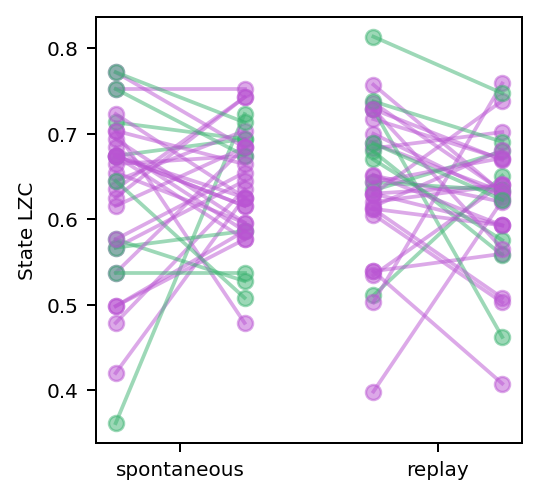

In [304]:
epoch_pairs = [  
    ['task00_spontaneous', 'task01_spontaneous'],
    ['task00_replay', 'task01_replay']
]

fig, ax = plt.subplots()
xoffset = 0.25  # determines spacing between pairs of points

for idx, session in df_hmm.iterrows():
    pos = 0  # increment x-position for each epoch pair
    for epochs in epoch_pairs:
        # Get the data to plot
        xx = pos + np.array([-xoffset, xoffset])
        yy = np.array([session[f'{epoch}_lzc'] for epoch in epochs])

        # Pick a color and linestyle
        color = CONTROLCOLOR if session['control_recording'] else LSDCOLOR
        
        # Plot pairs
        ax.plot(xx, yy, color=color, marker='o', alpha=0.5)
        
        pos += 1  # increment x-position

# Format axes
ax.set_xticks(range(len(epoch_pairs)))
ax.set_xticklabels([epochs[0].split('_')[1] for epochs in epoch_pairs])
ax.set_ylabel('State LZC')
plots.set_plotsize(w=6, h=6)

In [305]:
# Convert dataframe to long format
df_metric = df_hmm.melt(
    id_vars=['subject', 'eid', 'control_recording', 'trajectory_label'],
    value_vars=[col for col in df_hmm.columns if col.endswith(f'_lzc')],
    var_name='epoch',
    value_name='lzc'
).query('epoch.str.contains("task")').dropna()  # this ensures we are only including task_epochs

# Here, we split the task_epochs into two factors the task factor (pre or post treatment) and the epoch factor (visual sitmulation condition)
df_metric['task'] = df_metric['epoch'].apply(lambda x: x.split('_')[0])
df_metric['epoch'] = df_metric['epoch'].apply(lambda x: x.split('_')[1])

epochs = ['spontaneous', 'replay']
df_metric = df_metric[df_metric['epoch'].apply(lambda x: x in epochs)]  # Take only epochs of interest


# Build composite varibale for grouping
df_metric['subject_trajectory'] = df_metric.apply(lambda x: '_'.join([x['subject'], x['trajectory_label']]), axis='columns')

# Fit model with joint effects and random slopes/intercepts for each eid
model = smf.mixedlm(f'lzc ~ C(task, Treatment("task00")) + C(epoch, Treatment("spontaneous")) + C(control_recording) + ' + 
                    f'C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous")) + C(task, Treatment("task00"))*C(control_recording) + C(epoch, Treatment("spontaneous"))*C(control_recording)', 
                    data=df_metric,
                    ## FIXME: grouping variable should be mouse_trajectory composite variable
                    groups=df_metric['subject_trajectory'],  # Group by session
                    re_formula='~C(task, Treatment("task00")) + C(epoch, Treatment("spontaneous")) + C(control_recording) + ' +
                    'C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous")) + C(task, Treatment("task00"))*C(control_recording) + C(epoch, Treatment("spontaneous"))*C(control_recording)'
                   )  # Random slopes for all within-group predictors
result = model.fit()
print(result.summary())

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                                                                    Mixed Linear Model Regression Results
Model:                                                                MixedLM                                                   Dependent Variable:                                                   lzc     
No. Observations:                                                     132                                                       Method:                                                               REML    
No. Groups:                                                           29                                                        Scale:                                                                0.0052  
Min. group size:                                                      4                                                         Log-Likelihood:                                                       124.8378
Max. group size:                                  

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [258]:
df_spikes['coarse_region'].value_counts()

coarse_region
Striatum           2535
Thalamus           2085
Fiber tract        1677
Prefrontal Ctx     1610
None               1433
Supp. Motor Ctx    1281
Amygdala           1129
Hippocampus         675
Septum              663
Olfactory Ctx       604
Auditory Ctx        217
Claustrum           180
Motor Ctx           173
Somatosens. Ctx     164
Entorhinal Ctx      108
Habenula            101
Visual Ctx           99
Basal Forebrain      97
Hypothal             55
Name: count, dtype: int64

In [330]:
networks = {
    'cognitive': ['Prefrontal Ctx', 'Amygdala', 'Hippocampus' 'Septum', 'Entorhinal Ctx',],
    'affective': ['Prefrontal Ctx', 'Amygdala', 'Septum', 'Habenula', 'Hypothal'],
    'motor': ['Striatum', 'Thalamus', 'Supp. Motor Ctx', 'Motor Ctx', 'Somatosens. Ctx'],
    'sensory': ['Thalamus', 'Olfactory Ctx', 'Auditory Ctx', 'Somatosens. Ctx', 'Visual Ctx'],
    'state': ['Septum', 'Claustrum', 'Habenula', 'Basal Forebrain', 'Hypothal']
}

In [331]:
epochs = [
    'task00_spontaneous',
    'task01_spontaneous',
    'task00_replay',
    'task01_replay'
]
columns_to_keep = ['subject', 'eid', 'session_n', 'control_recording', 'start_time', 'trajectory_label']

K = 7

# eid = df_spikes['eid'].unique()[12]
# session = df_spikes.query('eid == @eid')
# regions = ['Striatum', 'Thalamus', 'Prefrontal Ctx', 'Supp. Motor Ctx', 'Motor Ctx']
# session = df_spikes.query('eid == @eid and coarse_region in @regions')
nw_hmm = {}
for nwlabel, regions in networks.items():
    hmm_datas = []
    sessions = df_spikes.query('coarse_region in @regions').groupby('eid')
    for _, neurons in tqdm(sessions, total=len(sessions)):
        if len(neurons) < 50:
            continue
        hmm_data = {col: neurons[col].unique()[0] for col in columns_to_keep}
        hmm_data['coarse_regions'] = neurons['coarse_region'].value_counts().to_dict()
        
        # Dimensionality reduction on full recording
        X = np.stack(neurons['full_counts']).T
        X_norm = StandardScaler().fit_transform(X)
        pca = PCA()
        pca.fit(X_norm)
        D = np.searchsorted(np.cumsum(pca.explained_variance_ratio_), 0.8)
            
        for epoch in epochs:
            X = np.stack(neurons[f'{epoch}_counts']).T
            X_norm = StandardScaler().fit_transform(X)
            X_pca = pca.transform(X_norm)
            
            model = hmm.GaussianHMM(n_components=K, covariance_type='diag', n_iter=200, tol=0.001, random_state=1, algorithm='viterbi')
            model.fit(X_pca[:, :D])
            # ll = model.score(X_pca[:, :D])
            # print(ll)
            posteriors = model.predict_proba(X_pca[:, :D])
            states = model.predict(X_pca[:, :D])
            # durations = evaluate_hmm(states, dt)
            
            hmm_data[f'{epoch}_converged'] = model.monitor_.converged
            hmm_data[f'{epoch}_posteriors'] = posteriors
            hmm_data[f'{epoch}_states'] = states
            hmm_data[f'{epoch}_occupancy'] = get_state_occupancy(states, K)
        hmm_datas.append(hmm_data)
    nw_hmm[nwlabel] = pd.DataFrame(hmm_datas)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.27it/s]


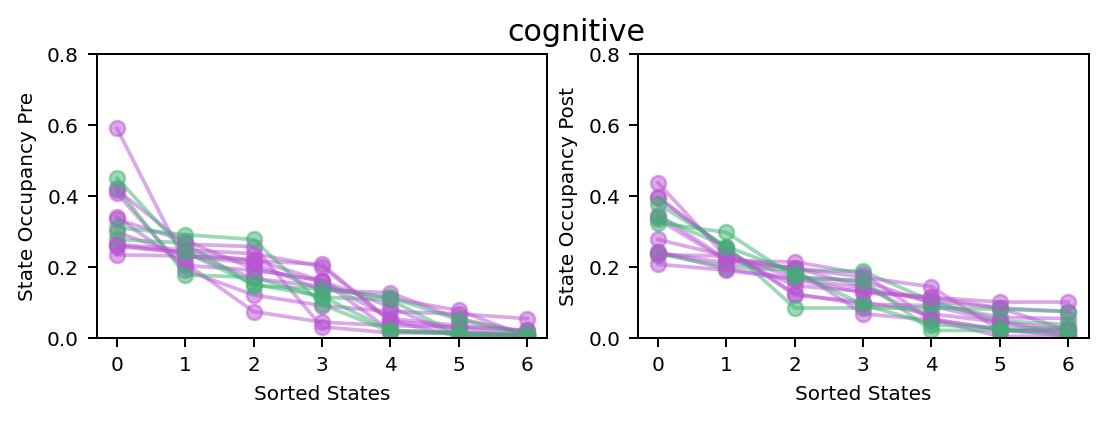

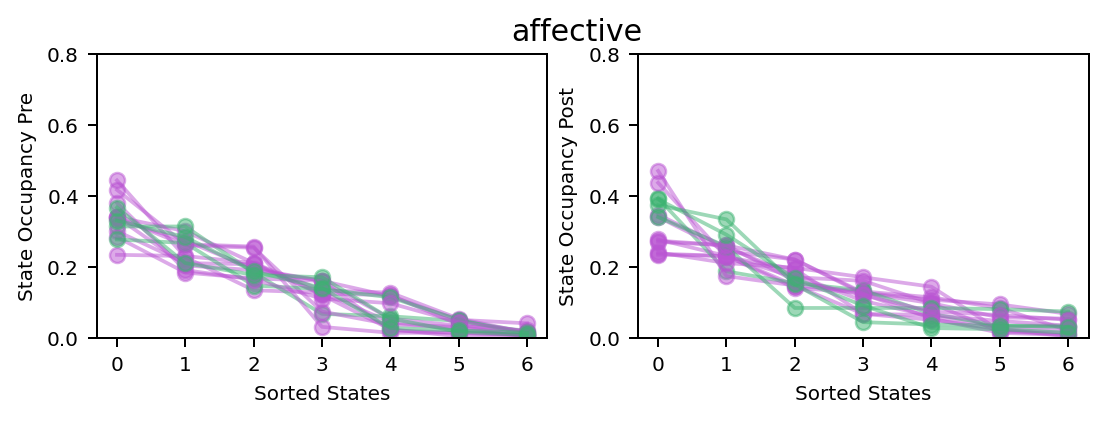

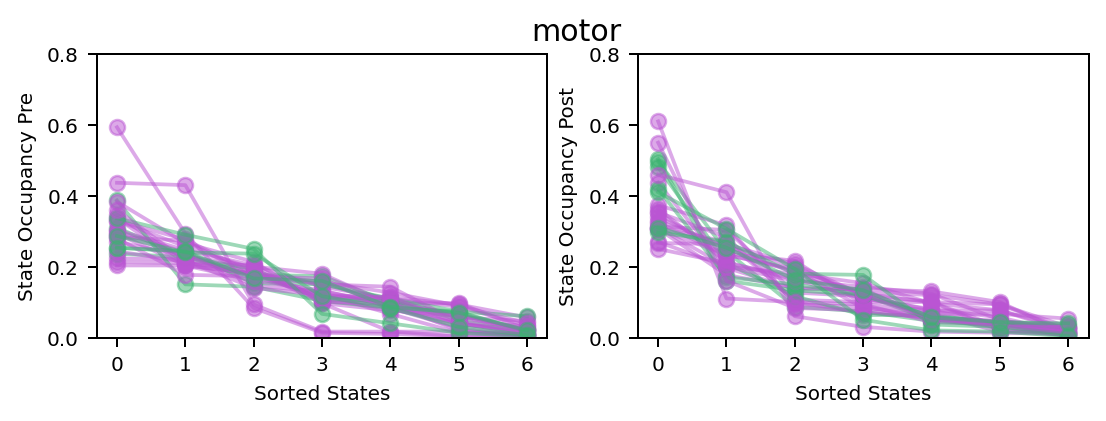

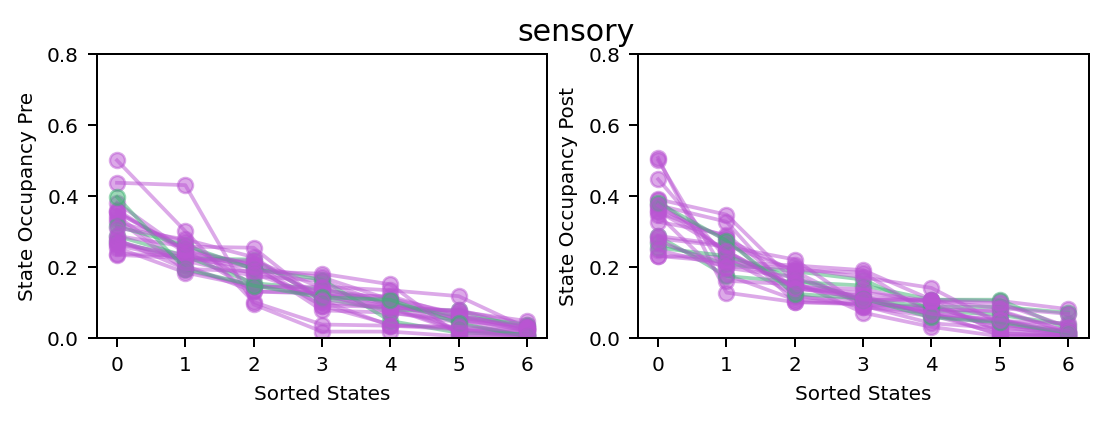

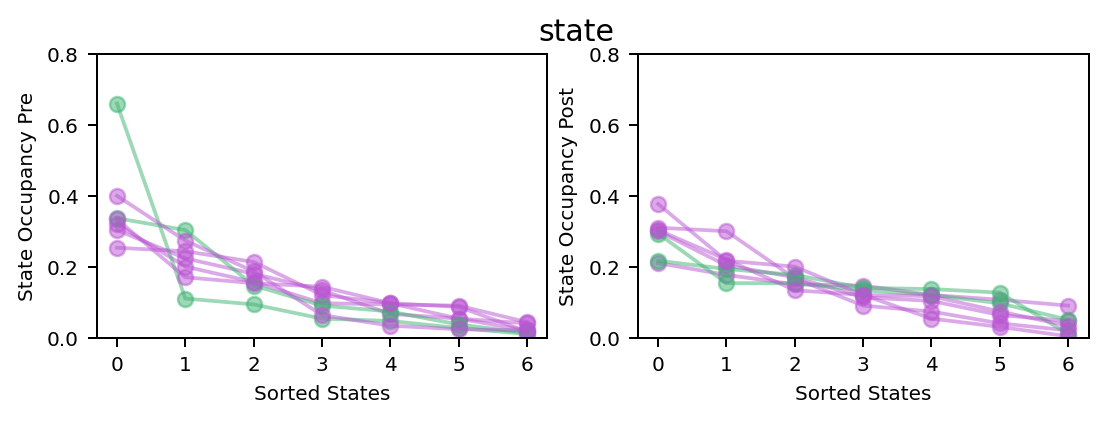

In [332]:
epoch = 'spontaneous'

for nwlabel, df_hmm in nw_hmm.items():
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(nwlabel)
    
    for ax, task, label in zip(axs, ['task00', 'task01'], ['Pre', 'Post']):
        for idx, session in df_hmm.iterrows():
            # Sort states by occupancy
            sorted_occupancies = np.flip(np.sort(session[f'{task}_{epoch}_occupancy']))
            
            # Create x positions for each state
            xx = np.arange(K)
            yy = sorted_occupancies
            
            # Pick a color based on condition
            color = CONTROLCOLOR if session['control_recording'] else LSDCOLOR
            
            # Plot connected line for this session
            ax.plot(xx, yy, color=color, marker='o', alpha=0.5)
        
        # Format axes
        ax.set_xticks(range(K))
        ax.set_xlabel('Sorted States')
        ax.set_ylim([0, 0.8])
        ax.set_ylabel(f'State Occupancy {label}')
        plots.set_plotsize(w=14, h=4)

In [333]:
for nwlabel, df_hmm in nw_hmm.items():
    print(nwlabel.capitalize())
    epochs = [
        'task00_spontaneous',
        'task01_spontaneous',
        'task00_replay',
        'task01_replay'
    ]

    for epoch in epochs:
        df_hmm[f'{epoch}_entropy'] = df_hmm[f'{epoch}_occupancy'].apply(util.normalized_entropy)
        df_hmm[f'{epoch}_S1'] = df_hmm[f'{epoch}_occupancy'].apply(lambda x: x.max())
    
    # Convert dataframe to long format
    df_metric = df_hmm.melt(
        id_vars=['subject', 'eid', 'control_recording'],
        value_vars=[col for col in df_hmm.columns if col.endswith(f'_entropy')],
        var_name='epoch',
        value_name='entropy'
    ).dropna()  # this ensures we are only including task_epochs
    
    # Here, we split the task_epochs into two factors the task factor (pre or post treatment) and the epoch factor (visual sitmulation condition)
    df_metric['task'] = df_metric['epoch'].apply(lambda x: x.split('_')[0])
    df_metric['epoch'] = df_metric['epoch'].apply(lambda x: x.split('_')[1])
    
    epochs = ['spontaneous', 'replay']
    df_metric = df_metric[df_metric['epoch'].apply(lambda x: x in epochs)]  # Take only epochs of interest
    
    # Fit model with joint effects and random slopes/intercepts for each eid
    model = smf.mixedlm(f'entropy ~ C(task, Treatment("task00")) + C(epoch, Treatment("spontaneous")) + C(control_recording) + ' + 
                        f'C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous")) + C(task, Treatment("task00"))*C(control_recording) + C(epoch, Treatment("spontaneous"))*C(control_recording)', 
                        data=df_metric,
                        ## FIXME: grouping variable should be mouse_trajectory composite variable
                        groups=df_metric['subject'],  # Group by session
                        re_formula='~C(task, Treatment("task00")) + C(epoch, Treatment("spontaneous")) + C(control_recording) + ' +
                        'C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous")) + C(task, Treatment("task00"))*C(control_recording) + C(epoch, Treatment("spontaneous"))*C(control_recording)'
                       )  # Random slopes for all within-group predictors
    result = model.fit()
    print(result.summary())

Cognitive


/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

                                                                                    Mixed Linear Model Regression Results
Model:                                                               MixedLM                                                    Dependent Variable:                                                    entropy
No. Observations:                                                    56                                                         Method:                                                                REML   
No. Groups:                                                          11                                                         Scale:                                                                 0.0013 
Min. group size:                                                     4                                                          Log-Likelihood:                                                        70.1894
Max. group size:                                  

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

                                                                                    Mixed Linear Model Regression Results
Model:                                                               MixedLM                                                    Dependent Variable:                                                    entropy
No. Observations:                                                    56                                                         Method:                                                                REML   
No. Groups:                                                          11                                                         Scale:                                                                 0.0012 
Min. group size:                                                     4                                                          Log-Likelihood:                                                        78.2570
Max. group size:                                  

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                                                                                    Mixed Linear Model Regression Results
Model:                                                                MixedLM                                                   Dependent Variable:                                                   entropy 
No. Observations:                                                     104                                                       Method:                                                               REML    
No. Groups:                                                           16                                                        Scale:                                                                0.0023  
Min. group size:                                                      4                                                         Log-Likelihood:                                                       133.9892
Max. group size:                                  

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsm

                                                                                    Mixed Linear Model Regression Results
Model:                                                                MixedLM                                                   Dependent Variable:                                                   entropy 
No. Observations:                                                     88                                                        Method:                                                               REML    
No. Groups:                                                           14                                                        Scale:                                                                0.0020  
Min. group size:                                                      4                                                         Log-Likelihood:                                                       114.1958
Max. group size:                                  

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


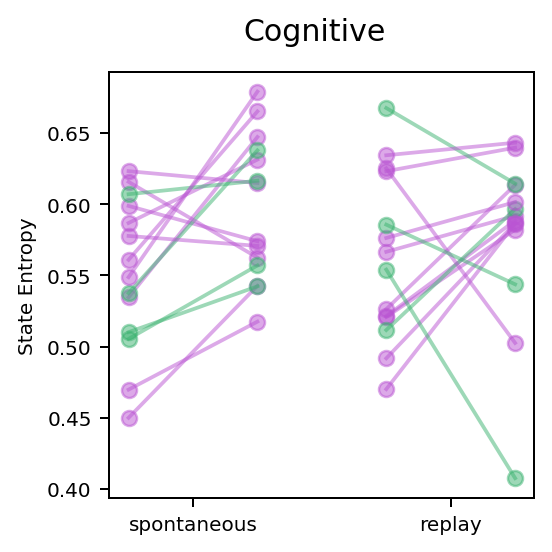

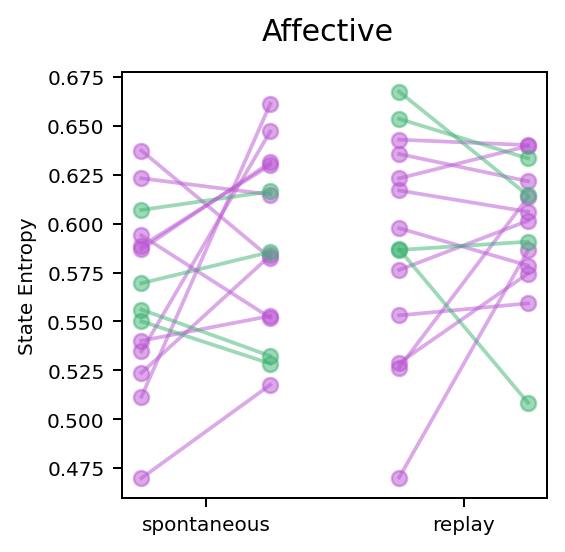

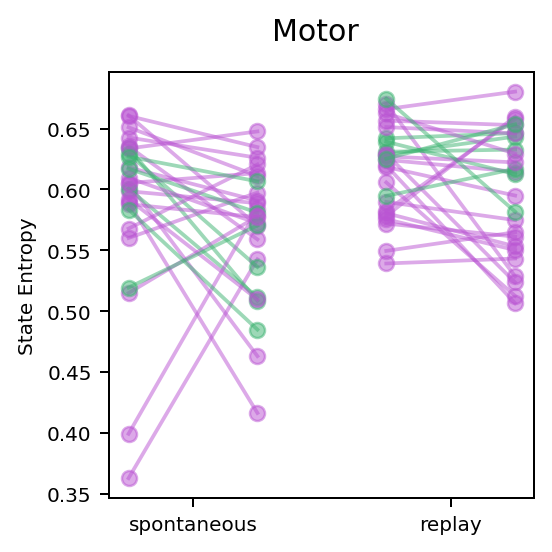

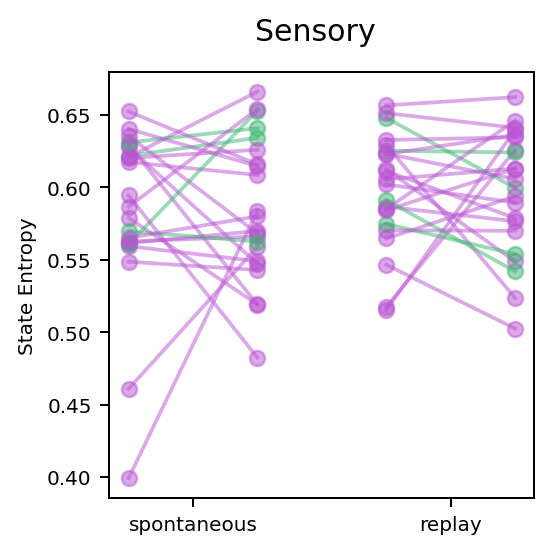

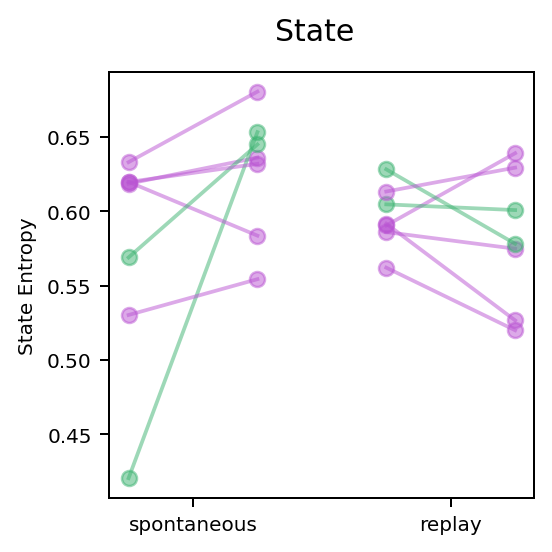

In [334]:
epoch_pairs = [  
    ['task00_spontaneous', 'task01_spontaneous'],
    ['task00_replay', 'task01_replay']
]

for nwlabel, df_hmm in nw_hmm.items():
    epochs = [
        'task00_spontaneous',
        'task01_spontaneous',
        'task00_replay',
        'task01_replay'
    ]

    for epoch in epochs:
        df_hmm[f'{epoch}_entropy'] = df_hmm[f'{epoch}_occupancy'].apply(util.normalized_entropy)
        df_hmm[f'{epoch}_S1'] = df_hmm[f'{epoch}_occupancy'].apply(lambda x: x.max())
    fig, ax = plt.subplots()
    fig.suptitle(nwlabel.capitalize())
    xoffset = 0.25  # determines spacing between pairs of points
    
    for idx, session in df_hmm.iterrows():
        pos = 0  # increment x-position for each epoch pair
        for epochs in epoch_pairs:
            # Get the data to plot
            xx = pos + np.array([-xoffset, xoffset])
            yy = np.array([session[f'{epoch}_entropy'] for epoch in epochs])
    
            # Pick a color and linestyle
            color = CONTROLCOLOR if session['control_recording'] else LSDCOLOR
            
            # Plot pairs
            ax.plot(xx, yy, color=color, marker='o', alpha=0.5)
            
            pos += 1  # increment x-position
    
    # Format axes
    ax.set_xticks(range(len(epoch_pairs)))
    ax.set_xticklabels([epochs[0].split('_')[1] for epochs in epoch_pairs])
    ax.set_ylabel('State Entropy')
    plots.set_plotsize(w=6, h=6)

In [315]:
epochs = [
    'task00_spontaneous',
    'task01_spontaneous',
    'task00_replay',
    'task01_replay'
]

for epoch in epochs:
    df_spikes[f'{epoch}_lzc'] = df_spikes[f'{epoch}_counts'].apply(lambda x: lziv_complexity((x > np.median(x)).astype(int), normalize=True))

Amygdala: fitting multi-level model with 1 subjects in both conditions
Auditory Ctx: skipping, too few neurons per condition!
Basal Forebrain: fitting multi-level model with 1 subjects in both conditions
Model failed to converge for coarse_region Basal Forebrain
Claustrum: reverting to OLS (ANOVA), too few subjects per condition!
Entorhinal Ctx: skipping, too few neurons per condition!
Fiber tract: fitting multi-level model with 1 subjects in both conditions


/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.984837
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/

Habenula: reverting to OLS (ANOVA), too few subjects per condition!
Hippocampus: fitting multi-level model with 1 subjects in both conditions
Hypothal: fitting multi-level model with 1 subjects in both conditions
Motor Ctx: skipping, too few neurons per condition!
None: reverting to OLS (ANOVA), too few subjects per condition!
Olfactory Ctx: reverting to OLS (ANOVA), too few subjects per condition!
Prefrontal Ctx: fitting multi-level model with 1 subjects in both conditions
Septum: fitting multi-level model with 1 subjects in both conditions


/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixe

Somatosens. Ctx: skipping, too few neurons per condition!
Striatum: fitting multi-level model with 1 subjects in both conditions
Supp. Motor Ctx: reverting to OLS (ANOVA), too few subjects per condition!
Thalamus: fitting multi-level model with 1 subjects in both conditions


/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_364715/3753611677.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pvals = df_spikes.groupby('coarse_region').apply(_mixed_lm)


Visual Ctx: skipping, too few neurons per condition!


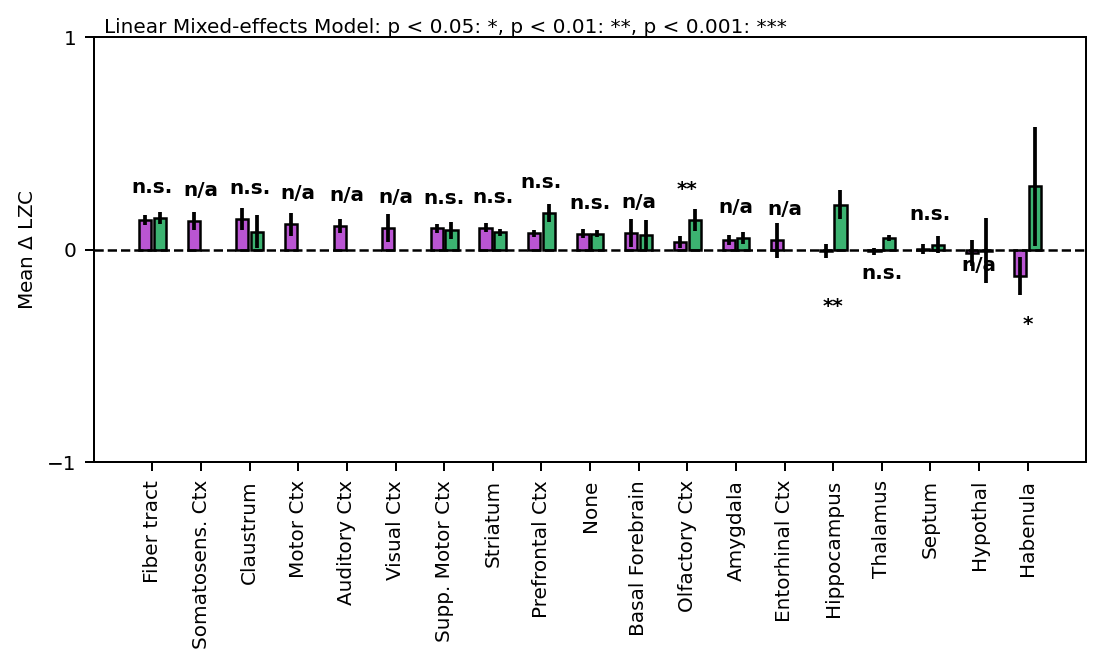

In [337]:
epoch = 'spontaneous'
fig, ax = plt.subplots()

# # Prepare data: keep only significant neurons
# df = df_MI.dropna(subset=[f'{epoch}_MI']).query(f'{epoch}_p < 0.025 or {epoch}_p > 0.975')

df_spikes[f'{epoch}_lzcdiff'] = df_spikes.apply(lambda x: x[f'task01_{epoch}_lzc'] - x[f'task00_{epoch}_lzc'], axis='columns')

# Compute mean MI per region (all data), for sorting
region_means = df_spikes.groupby('coarse_region')[f'{epoch}_lzcdiff'].mean()
sorted_regions = region_means.sort_values(ascending=False).index.tolist()

# Compute means and errors for each group (control and LSD/experimental)
LZC = df_spikes.groupby(['coarse_region', 'control_recording'])[f'{epoch}_lzcdiff'].agg(['mean', 'sem']).unstack()

def _mixed_lm(group_data, min_n_neurons=7):
    group_data.reset_index(drop=True, inplace=True)
    min_neurons_per_condition = min(sum(group_data['control_recording'] == True), sum(group_data['control_recording'] == False))
    n_subjects_both_conditions = sum(group_data.groupby('subject')['control_recording'].nunique() == 2)
    
    if min_neurons_per_condition < min_n_neurons:
        print(f"{group_data.name}: skipping, too few neurons per condition!")
        return np.nan
    elif n_subjects_both_conditions < 1:
        print(f"{group_data.name}: reverting to OLS (ANOVA), too few subjects per condition!")
        model = smf.ols(f'{epoch}_lzcdiff ~ C(control_recording)', group_data)
        result = model.fit()
    else:
        print(f"{group_data.name}: fitting multi-level model with {n_subjects_both_conditions} subjects in both conditions")
        model = smf.mixedlm(f'{epoch}_lzcdiff ~ C(control_recording)', group_data, groups=group_data['subject'], re_formula='~C(control_recording)')
        try:
            result = model.fit(method='lbfgs')
            if not result.converged:
                print(f"Model failed to converge for coarse_region {group_data.name}")
                return np.nan
        except:
            return np.nan
    return result.pvalues['C(control_recording)[T.True]']
pvals = df_spikes.groupby('coarse_region').apply(_mixed_lm)

xpos = np.arange(len(sorted_regions))
for control, offset in zip([False, True], [-0.15, 0.15]):
    means = LZC['mean'].loc[sorted_regions, control].values
    err   = LZC['sem'].loc[sorted_regions, control].values * 1.96
    color = CONTROLCOLOR if control else LSDCOLOR
    ax.bar(xpos + offset, means, yerr=err, width=0.25, color=color, edgecolor='k')

for i, region in enumerate(sorted_regions):
    p = pvals.loc[region]
    h_control = LZC['mean'].loc[region, True]
    h_lsd   = LZC['mean'].loc[region, False]
    ypos = np.nanmax([np.abs(h_lsd), np.abs(h_control)]) * np.sign(h_lsd)
    ax.text(xpos[i], ypos + (0.1 * np.sign(ypos)), plots.pval2stars(p), ha='center', va='bottom', fontsize=plots.LABELFONTSIZE, fontweight='bold', color='k')

ax.axhline(0, color='k', linewidth=1, linestyle='--')
ax.set_xticks(xpos)
ax.set_xticklabels(sorted_regions, rotation=90)
ax.set_yticks([-1, 0, 1])
ax.set_ylabel('Mean $\Delta$ LZC')

# ax.text(xpos[0] - 1, 0.01, 'Higher rate after treatment >', fontsize=plots.LABELFONTSIZE, va='bottom', ha='left', rotation=90)
# ax.text(xpos[-1] + 1, -0.01, 'Lower rate after treatment >', fontsize=plots.LABELFONTSIZE, va='top', ha='right', rotation=270)
ax.text(0.01, 1.01, 'Linear Mixed-effects Model: p < 0.05: *, p < 0.01: **, p < 0.001: ***', 
        transform=ax.transAxes, fontsize=plots.LABELFONTSIZE)

plots.set_plotsize(w=14, h=6)

In [ ]:
def population_lzc(binary_array, method='majority'):
    """
    Reduce population to single binary value per timepoint.
    
    Parameters
    ----------
    spike_counts_binary : array, shape (n_timepoints, n_neurons)
    method : str
        'majority': 1 if >50% neurons active
        'weighted': 1 if weighted sum > threshold
        'pca': 1 if first PC > 0
    
    Returns
    -------
    lz : float
    """
    if method == 'majority':
        pop_binary = (spike_counts_binary.mean(axis=1) > 0.5).astype(int)
    
    elif method == 'weighted':
        # Weight by neuron firing rates
        weights = spike_counts_binary.sum(axis=0)
        weights = weights / weights.sum()
        pop_activity = spike_counts_binary @ weights
        pop_binary = (pop_activity > np.median(pop_activity)).astype(int)
    
    elif method == 'pca':
        from sklearn.decomposition import PCA
        pca = PCA(n_components=1)
        pc1 = pca.fit_transform(spike_counts_binary).flatten()
        pop_binary = (pc1 > 0).astype(int)
    
    lz = lempel_ziv_complexity(pop_binary)
    return lz

5


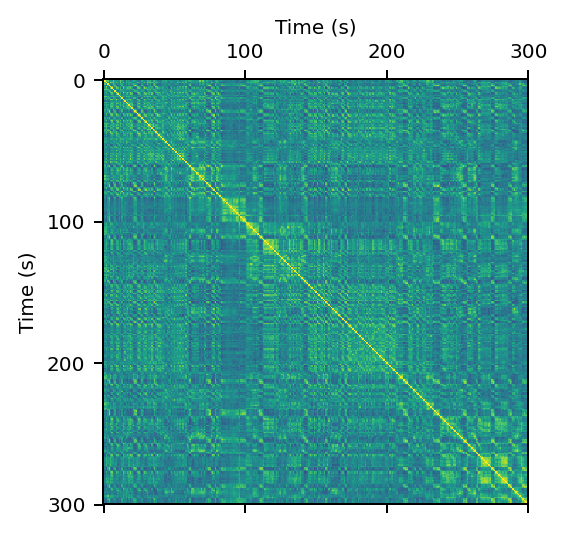

In [25]:
fig, ax = plt.subplots()
X = np.stack(session['task00_spontaneous_counts']).T
X_norm = StandardScaler().fit_transform(X)
pca = PCA(n_components=60)
X_pcs = pca.fit_transform(X_norm) 
D = cosine_similarity(X_pcs)
pca = PCA()
pca.fit(StandardScaler().fit_transform(D))
print(np.cumsum(pca.explained_variance_ratio_).searchsorted(0.8))
ax.matshow(D, vmin=-1, vmax=1)
ax.set_xticks([0, 100, 200, 300])
ax.xaxis.set_label_position('top') 
ax.set_xlabel('Time (s)')
ax.set_yticks([0, 100, 200, 300])
ax.set_ylabel('Time (s)')
plots.set_plotsize(w=6)